# 4 - Generative Adversarial Network

`github.com/samph4`

~

## Preface

This example will be more in-depth than the first few, but a lot of the principles that we have already applied also apply here. As always, we'll go through it step by step and I'll do my best to explain each part so that it makes sense and is as easy to follow as I can make it. In this final example, we will be looking at Generative Adversarial Networks - affectionately known as GANs. The concept of GANs were first introduced by Ian Goodfellow and his team in 2014 (https://arxiv.org/abs/1406.2661), where they "proposed a new framework for estimating generative models via an an adversarial process". I'll get into this in much more detail, but essentially what is happening here is that we are going to train two neural networks (that will be adversaries), that will compete against one another in order to improve. One will be reffered to as the Discriminator and the other will be known as the Generator. We combine both of these networks to form a combined model known as the GAN for training. Once training has been completed, we want to be able to use the *trained* Generator network independently to generate new things!

![Image](./Figures/gan2.png)

The image above looks rather unassuming, it is simply a row of portraits of four different people. The interesting thing however, is that none of these people actually exist. They are not real. Each of these images has been generated by a Generative Adversarial Network known as StyleGAN. StyleGAN is a sophisticated GAN that has been curated and trained by NVIDIA and represents the state-of-the-art results in data-driven unconditional generative image modelling and is an impressive testament as to the possibilities of Generative Networks. Here is another video that demonstrates the capabilities of these methods (which is only 2 minutes long so I recommend you watch it because it's v cool) - https://www.youtube.com/watch?v=p5U4NgVGAwg. With that being said, lets take a closer look as to how these things actually work.

## Generative Adversarial Networks

![Image](./Figures/gan1.png)

The Generative Adversarial Network is a framework for estimating generative models via an adversarial process in which two neural networks compete against each other during training. It is a useful machine learning technique that learns to generate fake samples indistinguishable from real ones via a competitive game. Whilst this may sound a little confusing, the GAN is nothing more than a combined model where two neural networks are joined together; these are known as the Discriminator $D$ and the Generator $G$. The Discriminator $D$ is a classification network that is set up to maximise the probability of assigning the correct label to real (label 1) or fake (label 0) samples. Meanwhile, the Generator $G$ is trying to fool $D$ and generate new samples that the Discriminator believes came from the training set. Mathematically speaking, this corresponds to the following two-player minimax game with value function $V(G,D)$:

![Image](./Figures/minmax.png)

Where $x$ is the input to $D$ from the training set, $z$ is a vector of latent values input to $G$, $E_x$ is the expected value overall real data instances, $D(x)$ is the Discriminator’s estimate of the probability that real data instance $x$ is real, $E_z$ is the expected value over all random inputs to the generator and $D(G(z))$ is the discriminator’s estimate of the probability that a fake instance is real. The diagram above should help this bit make sense. To reiterate, the primary goal of $G$ is to fool $D$ and generate new samples that $D$ believes came from the training set (real). The primary goal of $D$ is to correctly classify real/fake samples by assigning a label of 0 to generated samples indicating a fake, and a label of 1 to true samples indicating that it is real and came from the training set. The training procedure for $G$ is to maximise the probablity of $D$ making a mistake i.e. an incorrect classification. In the space of arbitrary functions $G$ and $D$, a unique solution exists, with $G$ able to reproduce data with the same distribution as the training set and the output from $D$ ≈ 0.5 for all samples, which simply indicates that the discriminator can no longer differentiate between the training data and the data generated by $G$. Or in other words, the Generator $G$ has got so good at generating 'fake' data that $D$ can no longer tell the difference. The image below is taken from Google's training documentation about GANs and is worth a read as it (obviously) does a good job at explaining some of these concepts (https://developers.google.com/machine-learning/gan).

![Image](./Figures/forge.png)

~


## Training Set

First of all, we need to decide what we want our generative network to generate. Of course, NVIDIA's sophisticated StyleGAN is capable of generating human faces, but GANs are capable of generating new data regardless of the form that it comes in. GANs can be used to generate new audio signals, new images, new time-series data etc. GANs are capable of generating new data that is representative of the data that it was trained on (the training set). Therefore, in large, a key factor in the success of the GAN model lies in the quality of the training set. In this example, we will create a simple training set from the function $y=sin(x)$ and use the trained generator to produce similar values!

```{note}
Throughout this example I may use terms such as 'real' and 'fake' when referring to data. Real refers to data samples that come from the training set and 'fake' samples refer to any data that is produced by the Generator.
```

### Import Libraries

As always, we'll start by importing the necessary libraries that we will use for this example. All of these functions we have used in previous examples so nothing should be too out of the ordinary, the `optimizers` and `initializers` however we will discuss later.

In [1]:
import numpy as np                                      # for working with arrays/data
from matplotlib import pyplot                           # for plotting!
from numpy.random import rand                           # explicit random number function
from numpy.random import randn                          # another explicit random function
from keras.models import Sequential                     # sequential model to create layered networks
from keras.layers import Dense                          # Dense layer (fully-connected MLP)
from keras.layers import LeakyReLU                      # LReLU Activation Function

from keras import optimizers
from keras import initializers

Using TensorFlow backend.


### Create Training (Target) Dataset

In the previous examples we had used the MNIST handwritten digits dataset. This is nice because not only is it a comprehensive dataset, but it is also labelled, properly structured, the images have been transformed/resized to give the machine learning algorithm the best chance to learn. But of course, depending on the problem that you are considering there will not always be a perfect dataset available. More often than not, you will have to create a training set yourself and structure it appropriately. Again, in this example we are just going to use the function $y=sin(x)$ to create a training set given a range of $x$ values between 0 and 2$\pi$. 

The training data will exist as a 2-D array consisting of the $x$ and corresponding $y$ values of the $sin(x)$ function. We can start by creating a new variable called `dataset` and preallocate an array of zero values with the number of rows dependant on the number of samples we would like, in this case I choose 20, and 2 columns for the $x$ and corresponding $y$ values. We use the `np.linspace()` function to create an array with `n1` equally spaced samples between 0 and 2$\pi$ and allocate them to the first (index = 0) column of the preallocated `dataset` array. We then use the `np.sin()` function to compute the sin values of each of the values in the first column and allocate them to the second column (index=1) of the `dataset` array. Finally, the `pyplot.scatter()` function from the `matplotlib` library is used to plot the training set. Of course, if you would like to change the number of values in this dataset you can do so by changing the value of `n1`.

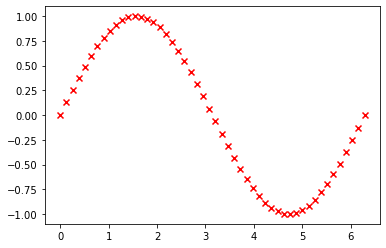

In [2]:
n1 = 50
dataset = np.zeros((n1,2))
dataset[:,0] = np.linspace(0,2*np.pi,n1)
dataset[:,1] = np.sin(dataset[:,0])

pyplot.scatter(dataset[:,0],dataset[:,1], marker='x',color='r')
pyplot.show()

### Functions in Python

The next section will list and talk through a bunch of different functions that we use in the training algorithm, but lets discuss how they work first. The majority of these functions are used to prepare the inputs to the Generator $G$ and the Discriminator $D$. If you have worked with functions in MATLAB then you might recall the syntax looks something like `function [y1,...,yN] = function_name(x1,...,xN)` where $x$ refers to the input variables and $y$ refers to the output variables. These functions are useful because there are often blocks of code that we might wish to repeat, and isntead of repeating the entire block of code, it is much better practice to remove the clutter and call a function that computes that block of code. Also, any of the variables created within the function that are not required as output are not saved as a global variable and will not take up unecessary memory.

In Python, the functionality is the same but the syntax is a little different. In order to define a function, we call `def` before naming the function. Take a look at the simple example below:

In [3]:
def simple_function(a,b):
    c = a + b
    return c

Here, we name the function `simple_function()`. You will notice that the function takes two inputs `a` and `b` and we define that by including them in the function parentheses and separating them with commas.

```{note}
Note the colon after the function, this is important as it initalises the function and lets Python know that the next bit of code you write will define what the function will actually do!
```

The outputs of the function are defined by the `return` statement. In this function we perform a simple addition of two input variables `a` and `b` and label that variable `c`. Adding `return c` at the end of the function does two things, it tells Python that the function statement is complete and also that we wish to return the variable `c` for use in the rest of our code! Note that the function here could be much more complicated with many more operations and variables within - if we wish to return additional variables for use in the rest of the code, we can simply return more values such as `return c, d, e, f, g` etc. Now we have defined a function, lets use it!

In [4]:
a = 1; b = 2 
c = simple_function(a,b)
print(c)

3


You can see that we can define variables `a` and `b` and insert them into the `simple_function()` that we defined previously. We can set this function equal to a new variable `c` to store the output from that function in variable `c`. If we print `c`, as expected the value is 3 (1+2). This is fine and it works, but there are a few more things you should be aware about. Python functions are very flexible! When we defined the function earlier, we named the variables `a` and `b`, but you'll see that it doesn't actually matter and we could have named them anything. How the variables are defined are only important in the function definition itself, so you'll see that this also works!

In [5]:
simple_function(4,5)

9

Also, Python functions allow you to set default values. You may have already noticed that when you import functions from libraries and call the `help()` function on them, you'll see a whole bunch of additional input options that you may or may not need/use. These parameters are often default that don't require changing for the function to work, but if you did wish to modify the function further then the option is there to change them. Lets define another function to explain that a little better:

In [6]:
def new_function(a,b,c=4):
    d = a + b + c 
    return d 

Here we define a new function that is very similar to the first, although this time we set a default parameter `c` as input and set a value of 4. We then define a new variable `d` within the function that is the sum of inputs `a`, `b` and `c` and return it for use in the rest of our code.

In [7]:
new_function(1,2)

7

Now when we call `new_function(1,2)` it returns a value of 7. This is because it is adding the values that we insert into the function (1,2) with the default parameter `c` which was equal to 4. This returns a value of 7 which is correct! We may wish to modify a default variable in the function (something we will do regurlarly when using the Keras machine learning functions) and we can easily do so as follows:

In [8]:
new_function(1,2,c=10)

13

You'll notice that we can simply override the default parameter by redefining its value when we call the function. By calling `new_function(1,2,c=10)` we replace the default `c` value of 4 to a value of 10. As expected, the function then returns a new value of 13 (1+2+10). To sum up, functions are a tool that are there to allow us to repeat complicated bits of code simply by calling a new function. There are two different types of input a function may require, ones that must be defined (such as `a` and `b` in this case) and ones that are default (`c`). It is important to understand that you do not have to define default values, if you don't the function will operate with the default values that have been preset. But if you try use a function without defining one of the essential values then the function will return an error message! But they're not that bad and once you get used to using and interacting with them you'll struggle to image a world where you didn't.

### Functions used in the GAN training algorithm

Here we will define a bunch of the functions used for the GAN training algorithm. Although some of them might be more complicated than the simple example we considered, the idea behind them is exactly the same.

#### Take Real Samples
To evaluate the performance of the GAN we will use the real data from the training set to train the Discriminator so that it can learn the characteristics of data that comes from the training set. This will make it easier for the Discriminator to label samples that come from the Generator as fake. We therefore create a simple function named `take_real_samples()` as it is simply taking real samples from the training set and will allow us to input them into the Discriminator for training. You will notice that the function returns two values; `X` and `y`. `X` refers to the values extracted from the training set and `y` is an array of ones to label the data as real!

Note, the first part of this function extracts a pre-defined number (n) of values randomly from the dataset. This is not necessary and you can definitely pass through the entire dataset on each iteration if you wish - this simply just shows a way of mixing things up and can sometimes be a useful technique when training networks. In NVIDIA's StyleGAN they intentionally add noise to different layers of their neural networks during training and find that the output from the trained networks become more flexible and less specific. This is often referred to as Mode Collapse and the extract from Google (below) does a good job at explaining what it means in reference to a GAN that generates faces:

> "Usually you want your GAN to produce a wide variety of outputs. You want, for example, a different face for every random input to your face generator. However, if a generator produces an especially plausible output, the generator may learn to produce only that output. In fact, the generator is always trying to find the one output that seems most plausible to the discriminator. If the generator starts producing the same output (or a small set of outputs) over and over again, the discriminator's best strategy is to learn to always reject that output. But if the next generation of discriminator gets stuck in a local minimum and doesn't find the best strategy, then it's too easy for the next generator iteration to find the most plausible output for the current discriminator. Each iteration of generator over-optimizes for a particular discriminator, and the discriminator never manages to learn its way out of the trap. As a result the generators rotate through a small set of output types. This form of GAN failure is called mode collapse." - Google GAN Tutorial (https://developers.google.com/machine-learning/gan/problems) 

In [9]:
def take_real_samples(n):
    #np.random.seed(30)
    idx = np.random.randint(len(dataset), size=int(n))
    X = dataset[idx,:]
    y = np.ones((n,1)) 
    
    return X, y

#### Generate points in latent space as input for the generator

Next, we define another function that sorts out the input to the Generator $G$. The input to the Generator in the GAN is known as the latent input. This is a weird name, but it is nothing more than a random input vector that we insert into the Generator. This is useful as it assures that the output from $G$ is varied and is the reason for the stochastic nature of the generative network.

> Stochastic - "Having a random probability distribution or pattern that may be analysed statistically but may not be predicted precisely."

We define the `create_latent_points()` function below to generate this 'latent' input that we will pass into the Generator to generate new samples. It takes inputs `latent_input` and `n` that we will define later. We imported the `randn` function earlier directly from the `numpy.random` module, equally we could call `np.random.randn` for the same result. `randn` returns a sample (or samples) from the "standard normal" distribution. The function returns `x_input` which will feed into $G$.

In [10]:
# generate points in latent space as input for the generator
def create_latent_points(latent_dim, n):
    # generate points in the latent space
    x_input = randn(latent_dim * n)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n, latent_dim)
    return x_input

#### Use the Generator to generate n fake examples, with class labels

The `generate_fake_samples()` function below calls the `create_latent_points()` function within that function, it is an example of a nested function which again you may or may not be familiar with from MATLAB. It collects the `x_input` from the `create_latent_points` function we defined earlier and inserts it directly into the `generator` model. It is important to remember that this example will take us through the creation of a GAN model and that GAN model is nothing more than a combination of a Discriminator and a Generator (two neural networks). As part of the training algorithm we will work directly with the $G$ and $D$ models and in this function we call the `predict` attribute from the `generator` variable that contains all of the information about the generator model. The `predict` attribute, as the name suggests, is the attribute that lets us actually use the generator to make predictions (generate new data). Here we use it to generate `n` fake samples and store them in variable `X`. As with the `take_real_samples`, we create another vector that stores the class label of 1 indicating fake samples.

In [11]:
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n):
    # generate points in latent space
    x_input = create_latent_points(latent_dim, n)
    # predict outputs
    X = generator.predict(x_input)
    # create class labels
    y = np.zeros((n, 1))
    return X, y

### Define GAN Model

Here we will define the structure of the neural networks. Remember that a GAN consists of two neural networks, a Discriminator $D$ and a Generator $G$. In this example, we are dealing with numeric data so a standard Multi-Layer Perceptron (MLP) network makes sense. We will define each network individually before creating a combined GAN model. As always, it is important for us to consider the shape of the input/output entering and leaving the networks. In the case of $D$, each input sample will be a vector containing two values - one for the $x$ value and another for its corresponding $y$ value - therefore 2 nodes in the input layer of the MLP network. Recall that $D$ is nothing more than a classification network, it's output will therefore be a single node that outputs a value between 0 and 1 corresponding to the confidence that it has that a sample came from a real (label = 1) or a fake (label = 0) distribution. The $G$ network is the latent input we discussed earlier. Recall that the latent input is nothing more than a vector of random numbers, so it's size will be equal to variable `latent_dim` which we can define later. The primary goal of $G$ is to generate samples that $$ believes came from the training set, and a single sample consists of an $x$ value and a corresponding $y$ value. Therefore the output of $G$ simply has two nodes in its output layer.



#### Discriminator

Again we use Keras' `Sequential()` model as it makes it very simple to add and play around with the layers in the network. The layers will look familiar to ones we have used in the previous examples, again the `Dense()` layer refers to a fully connected layer in which all the nodes in that layer are 'fully connected' to the ones in the previous and subsequent layer. 

```{note}
Note that here we define the discriminator in a function, of course the model could be made separately outside of the function but this allows us to exectute the whole algorithm later and if we change some parameters we will not have to execute this block of code again to reinitalise the model.
```

The function takes a default input that, unless changed, is of size 2 (as discussed earlier). The output layer includes a `Sigmoid` activation function that ensures that the output is modulated between 0 and 1. The key difference between this example and others is that here we have included a `kernel_initializer`. Initializers allow us to define the way to set the initial random weights of keras layers (see keras docs for more info - https://keras.io/api/layers/initializers/ - see this link for more info regarding `he_uniform` - https://www.tensorflow.org/api_docs/python/tf/keras/initializers/HeUniform). As always, we must remember to `compile` the model to define the loss function we will use, the optimizer and whatever metrics we may wish to track during training. As we defined the discriminator within a function, we have to remember to `return model` such that the actual model parameters can be stored and used elsewhere.

In [12]:
def define_discriminator(n_inputs=2):
    model = Sequential()
    model.add(Dense(25,  kernel_initializer='he_uniform', input_dim=n_inputs))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dense(15,  kernel_initializer='he_uniform'))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dense(10,  kernel_initializer='he_uniform'))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dense(5,  kernel_initializer='he_uniform'))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

#### Generator

Similarly, we define the Generator $G$. Again we define it as a function taking inputs `latent_dim` and a default number of outputs, `n_outputs` equal to 2. 

In [13]:
# define the standalone generator model
def define_generator(latent_dim, n_outputs=2):
    model = Sequential()
    model.add(Dense(15, activation='relu', kernel_initializer='he_uniform', input_dim=latent_dim))
    model.add(Dense(n_outputs, activation='linear'))
    return model

#### Combined GAN Model

Now that we have defined the $G$ and $D$ networks, we can combine them to form the combined GAN model. Again, we will use a function to do this and as you might expect the only inputs that it takes are the `generator` and the `discriminator`. We use Keras' `Sequential()` model and call the `model.add` attribute to add the entire model (in the same we add individual layers we can add entire networks!). Again we compile the model to define the loss function, optimizer and metrics we wish to track during training. You may have noticed that we include `disciminator.trainable = False`, the reason for this wil be explained in more detail shortly, but in short it is because the combined GAN model is used to train the Generator only. In order to train the Geneator and update it's parameters, the loss function requires $D(G(z))$ which corresponds to the Discriminators classification of the output of the Generators output given latent input $z$. The primary goal of $G$ is to generate fake samples that the Discriminator believes to be real, therefore for a given latent input $z$, we want the Discriminator to believe that a sample $G(z)$ has the same represenation as an input sample from training set $x$. Therefore a combined model is necessary such that we can optimise $G$ based on the output of $D$.

In [14]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(generator, discriminator):
    # make weights in the discriminator not trainable
    discriminator.trainable = False
    # connect them
    model = Sequential()
    # add generator
    model.add(generator)
    # add the discriminator
    model.add(discriminator)
    # compile model
    model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
    return model

## Evaluate Performance

At this point, the bulk of the code is written. We have defined functions that let us extract data from the training set and label it as real data accordingly (label = 0), a function that defines a random latent input from a Gaussian distribution, and finally a function that allows us to use $G$ to make predictions! We have also defined the acrhitecture of the Discriminator $D$, Generator $G$ and the combined GAN model. We can now start to develop the algorithm that controls the training procedure by defining a `train()` function and we will monitor the performance of the network during training with an additional function named `check_performance()`.

First, lets consider the `check_performance()` function. You can see that it takes inputs `epoch`, `generator`, `discriminator`, `latent_dim` and a default setting `n=10`. Variables `epochs` and `latent_dim` will be defined later. The function begins by calling the `take_real_samples(n)` function to extract real samples from the training set. We make the function equal to `x_real` and `y_real` as the function returns two variables, the first of which is the training data itself, and the second is the corresponding label (label=1 for real data). The value `n` simply dictates the number of samples we take from the training set. If `n` > than the number of samples in the training set, it will simply take all of the values from the training set. Next we call the `discriminator.evaluate()` attribute from the $D$ model to evaluate the performance of $D$ at that point during the training process. The `discriminator.evaluate()` function is useful as the model will not train on any data passed into the network. It takes both the training data and the label as input, we set the `verbose=0` simply to prevent any output. The evaluate function returns the values of any metrics that are being tracked, if we call `discriminator.metrics_names` we will see `['loss', 'accuracy']` printed. We can choose to monitor either, neither or both of these values if we wish. But lets say that we just want to monitor the accuracy, we can use the `_` command to ignore the first returned variable (in this case the loss) so that `_, acc_real` will only return the accuracy from that evaluation of the discriminator. We do a similar thing by calling `generate_fake_samples()` to store the fake data generated by $G$ and the fake label (label=0). We then call the `discriminator.evaluate()` once again but this time we evaluate the discriminator on the fake samples and test its performance! Again, we use the `_` command in Python to ignore the first returned variable (loss) and we stored the accuracy of the discriminator on the fake data (from generator) into variable `acc_fake`. We can then call the `print()` function to output the accuracies during training for that given epoch number. Finally, we can use the `matplotlib` library to plot some of the results. We plot the `real` data we used from the training set (as red crosses) and the `fake` data too! 

In [23]:
# evaluate the discriminator and plot real and fake points
def check_performance(epoch, generator, discriminator, latent_dim, n=10):
    # prepare real samples
    x_real, y_real = take_real_samples(n)
    # evaluate discriminator on real examples
    _, acc_real = discriminator.evaluate(x_real, y_real, verbose=0)
    # prepare fake examples
    x_fake, y_fake = generate_fake_samples(generator, latent_dim, n*4)
    # evaluate discriminator on fake examples
    _, acc_fake = discriminator.evaluate(x_fake, y_fake, verbose=0)
    # summarize discriminator performance
    print(epoch+1, acc_real, acc_fake)
    # scatter plot real and fake data points
    pyplot.scatter(x_real[:, 0], x_real[:, 1], marker='x', color='red')
    pyplot.scatter(x_fake[:, 0], x_fake[:, 1], marker='$\u25EF$', color='pink')
    pyplot.xlim([0, 6])
    pyplot.ylim([-1.5, 1.5])
    pyplot.show()

The last function we need to define is the `train` function itself. This function is an integral part of the algorithm and pieces together all of the functions that we have previously defined. As a result, it takes quite a few inputs in order to make it work. As you would expect, it requires information about the models so the `generator`, `discriminator` and the combined `gan_model` are called. Again, we need to define the size of the latent input to $G$ so `latent_dim` is also defined. The default variables include `n_epochs = 50000`, `n_batch=256` and `check_it=1000`. `n_epochs` defines the maximum number of epochs that the model will train for, in this case it is set to 50,000 but this is arbitrary. Obviously you can train for shorter or longer if you wish. `n_batch` determines the number of samples that are input to the network in that iteration, this is important when working with big data as you may need to lower the batch size so that you do not exceed the memory limits of your hardware (CPU/GPU). `check_it` is another default value that we use to trigger the `check_performance` function. 

We start the function by creating a new variable `half_batch`. This `half_batch` variable is used to split the batch_size in half and is exclusively used to train $D$. This is because we train $D$ on both the real data (from training set) and the fake data (from the generator), if we didn't half the batch size, then the discriminator would be exposed to twice as as much data as the generator and would therefore have a competitive advantage whereby the discriminator learns faster than generator and outcompetes the network. This makes it even more difficult for $G$ to produce samples that $D$ believes to be real and as such can result in unsuccessful training.  With this being said, to intiate the training algorithm we loop over the `n_epochs` that we defined. Only once 50,000 epochs have been met can we exit the loop and cease training.

```{tip}
We could include `break` statements into the loop a way to add additional stopping criteria such that once certain user-defined conditions have been met, the training will be terminated.
```

Inside the loop, we prepare our real and fake data in the same we defined in the previous function. However, this time we will actually use this data to train and update the parameters of the network. We train $D$ by calling the `discriminator.train_on_batch()` attribute from Keras. This function requires both the training data and its associated label. Therefore we call this function twice, first on the real data and next on the fake data! Next, we want to train the Generator $G$. We define the `x_gan` variable from the function `create_latent_points()` that we defined earlier that contains the latent input that we will input to the $G$. Similarly, we define `y_gan` as the label data for the fake samples!

```{note}
Remember that the naming convention typically used refers to X as the input, and Y as the output.
```

We can then call the same `train_on_batch` attribute on the $G$ model to train the generator. Note that within the GAN model we made the layers of the discriminator untrainable so they will not update during this step! Finally, we define a condition where if the current interation is a multiple of `check_it` (equal to 1,000), then it will execute the `check_performance()` which prints all the graphs etc and some of the performance metrics during training!

In [21]:
# train the generator and discriminator
def train(generator, discriminator, gan_model, latent_dim, n_epochs=50000, n_batch=100, check_it=1000):
    # determine half the size of one batch, for updating the discriminator
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_epochs):
        # prepare real samples
        x_real, y_real = take_real_samples(half_batch)
        # prepare fake examples
        x_fake, y_fake = generate_fake_samples(generator, latent_dim, half_batch)
        # update discriminator
        discriminator.train_on_batch(x_real, y_real)
        discriminator.train_on_batch(x_fake, y_fake)
        # prepare points in latent space as input for the generator
        x_gan = create_latent_points(latent_dim, n_batch)
        # create inverted labels for the fake samples
        y_gan = np.ones((n_batch, 1))
        # update the generator via the discriminator's error
        gan_model.train_on_batch(x_gan, y_gan)
        # evaluate the model every n_eval epochs
        if (i+1) % check_it == 0:
            check_performance(i, generator, discriminator, latent_dim)

## Execute the Model!

Running this cell block will initiate and execute the algorithm. We start by (finally) defining `latent_dim` which is simply the size of the random Gaussian vector that we input to $G$. Next we decide the names that we will use for each of the models, (creatively named `discriminator`, `generator` and `gan_model`). Finally calling the `train` function is the last step to execute the algorithm! 

C:\Users\Samuel\miniconda3\envs\tensorflow\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1000 0.30000001192092896 0.875


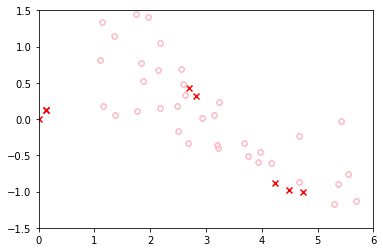

2000 0.30000001192092896 0.75


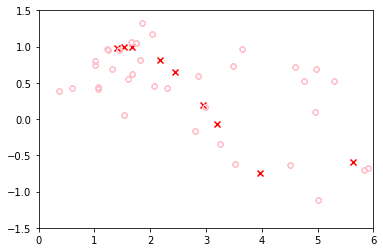

3000 0.8999999761581421 0.8500000238418579


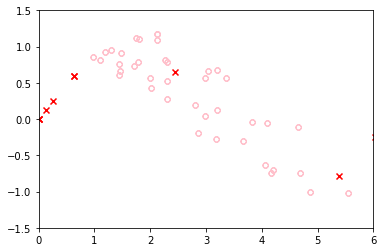

In [ ]:
# size of the latent space
latent_dim = 10
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# train model
train(generator, discriminator, gan_model, latent_dim)

In [ ]:
A, B = generate_fake_samples(generator, 10, 10000)
pyplot.scatter(A[:,0],A[:,1], marker='x',color='r')
pyplot.ylim([-1.5,1.5])
pyplot.xlim([0,6])